In [0]:
import numpy as np
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
  [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [0]:
def kl_loss(mu, sigma):
  return (-torch.log(sigma + 1e-8) + (sigma**2 + mu**2) / 2 - 1/2.).mean()

In [0]:
def eblo_loss(mu, sigma, x):
  return (0.5 * (x - mu)**2 / (sigma**2 + 1e-8) + torch.log(2. * np.pi * sigma)).mean()

In [0]:
class Encoder(nn.Module):
  def __init__(self, n, hidden=[100, 50], z_size=2):
    super(Encoder, self).__init__()
    layers = []
    for sz_last, sz in zip([n] + hidden, hidden):
      layers.append(nn.Linear(sz_last, sz))
      layers.append(nn.ReLU())
    self.model = nn.Sequential(*layers)
    self.mu = nn.Linear(hidden[-1], z_size)
    self.sigma = nn.Linear(hidden[-1], z_size)
  
  def forward(self, x):
    out = self.model(x)
    return self.mu(out), self.sigma(out)

In [0]:
class Decoder(nn.Module):
  def __init__(self, n, hidden=[50, 100], z_size=2):
    super(Decoder, self).__init__()
    layers = []
    for sz_last, sz in zip([z_size] + hidden, hidden):
      layers.append(nn.Linear(sz_last, sz))
      layers.append(nn.ReLU())
    self.model = nn.Sequential(*layers)
    self.mu = nn.Linear(hidden[-1], n)
    self.sigma = nn.Linear(hidden[-1], n)
  
  def forward(self, z):
    out = self.model(z)
    return self.mu(out), self.sigma(out)

In [0]:
class ScalarDecoder(nn.Module):
  def __init__(self, n, hidden=[50, 100], z_size=2):
    super(ScalarDecoder, self).__init__()
    layers = []
    for sz_last, sz in zip([z_size] + hidden, hidden):
      layers.append(nn.Linear(sz_last, sz))
      layers.append(nn.ReLU())
    self.model = nn.Sequential(*layers)
    self.mu = nn.Linear(hidden[-1], n)
    self.sigma = nn.Linear(hidden[-1], 1)
  
  def forward(self, z):
    out = self.model(z)
    return self.mu(out), self.sigma(out)

In [0]:
def sample(mu, sigma):
  eps = torch.randn_like(mu)
  return mu + sigma * eps

class VAE(nn.Module):
  def __init__(self, n, hidden=[50, 100], z_size=2, is_scalar=False):
    super(VAE, self).__init__()
    self.encoder = Encoder(n, hidden, z_size)
    self.decoder = Decoder(n, list(reversed(hidden)), z_size) if not is_scalar else ScalarDecoder(n, list(reversed(hidden)), z_size)

  def forward(self, x):
    z_mu, z_sigma = self.encoder(x)
    z_sigma = F.relu(z_sigma) + 1e-8
    z = sample(z_mu, z_sigma)

    x_mu, x_sigma = self.decoder(z)
    x_sigma = F.relu(x_sigma) + 1e-8
    out = sample(x_mu, x_sigma)

    z_loss = kl_loss(z_mu, z_sigma)
    out_loss = eblo_loss(x_mu, x_sigma, x)

    return x_mu, x_sigma, z_loss, out_loss

In [155]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

data_1 = torch.from_numpy(sample_data_1()).float()
data_2 = torch.from_numpy(sample_data_2()).float()

cuda:0


In [0]:
def learn(data, model, epoches, batch_size, optimizer):
    train_losses = []
    eblo_losses = []
    kl_losses = []

    iters_per_epoch = int(len(data) / batch_size)
    
    for epoch in range(epoches):
        for i in range(iters_per_epoch):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)

            x_mu, x_sigma, z_loss, out_loss = model(batch)
            train_error    = out_loss + z_loss
            
            train_losses.append(float(train_error))
            eblo_losses.append(float(out_loss))
            kl_losses.append(float(z_loss))

            print("\rEpoch {}/{}. Iteration {}/{} Losses: train: {}"
              .format(epoch, epoches, i, iters_per_epoch, train_losses[-1]), end="")

            train_error.backward()   
            optimizer.step()
            optimizer.zero_grad()
    return train_losses, eblo_losses, kl_losses

Epoch 9/10. Iteration 999/1000 Losses: train: 3.1907637119293213

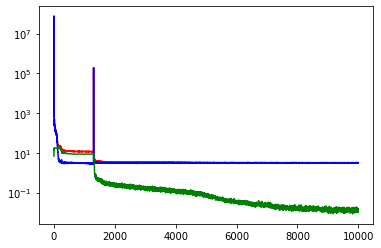

In [0]:
model = VAE(2).to(device)
opt = torch.optim.Adam(model.parameters())
train_losses, eblo_losses, kl_losses = learn(data_1, model, 10, 100, opt)

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(eblo_losses)), eblo_losses, 'b',
         range(0, len(kl_losses)), kl_losses, 'g'
         )

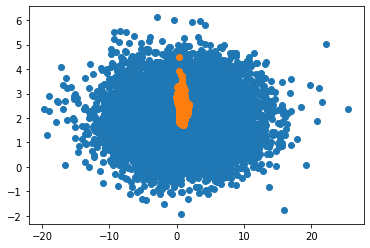

In [0]:
x_mu, x_sigma = model.decoder(torch.randn(10000, 2).to(device))
xs = x_mu + x_sigma * torch.randn_like(x_mu)
plt.scatter(xs[:, 0].cpu().detach().numpy(), xs[:, 1].cpu().detach().numpy())
plt.scatter(x_mu[:, 0].cpu().detach().numpy(), x_mu[:, 1].cpu().detach().numpy())

Epoch 9/10. Iteration 999/1000 Losses: train: 3.198662757873535

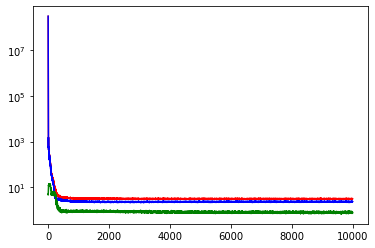

In [0]:
model = VAE(2).to(device)
opt = torch.optim.Adam(model.parameters())
train_losses, eblo_losses, kl_losses = learn(data_2, model, 10, 100, opt)

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(eblo_losses)), eblo_losses, 'b',
         range(0, len(kl_losses)), kl_losses, 'g'
         )

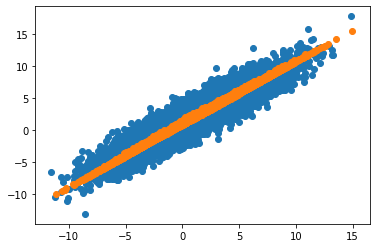

In [0]:
x_mu, x_sigma = model.decoder(torch.randn(10000, 2).to(device))
xs = x_mu + x_sigma * torch.randn_like(x_mu)
plt.scatter(xs[:, 0].cpu().detach().numpy(), xs[:, 1].cpu().detach().numpy())
plt.scatter(x_mu[:, 0].cpu().detach().numpy(), x_mu[:, 1].cpu().detach().numpy())

Epoch 9/10. Iteration 999/1000 Losses: train: 4.4812703132629395

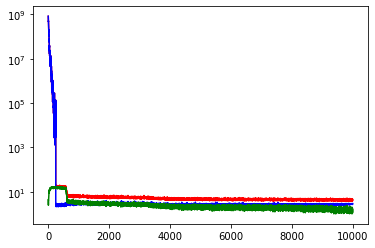

In [0]:
model = VAE(2, is_scalar=True).to(device)
opt = torch.optim.Adam(model.parameters())
train_losses, eblo_losses, kl_losses = learn(data_1, model, 10, 100, opt)

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(eblo_losses)), eblo_losses, 'b',
         range(0, len(kl_losses)), kl_losses, 'g'
         )

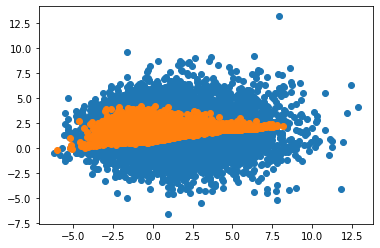

In [0]:
x_mu, x_sigma = model.decoder(torch.randn(10000, 2).to(device))
xs = x_mu + x_sigma * torch.randn_like(x_mu)
plt.scatter(xs[:, 0].cpu().detach().numpy(), xs[:, 1].cpu().detach().numpy())
plt.scatter(x_mu[:, 0].cpu().detach().numpy(), x_mu[:, 1].cpu().detach().numpy())

Epoch 9/10. Iteration 999/1000 Losses: train: 3.239529609680176

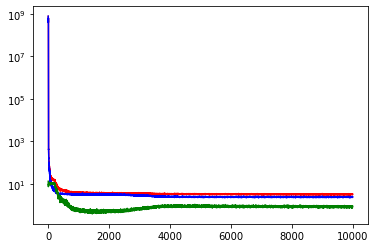

In [143]:
model = VAE(2, is_scalar=True).to(device)
opt = torch.optim.Adam(model.parameters())
train_losses, eblo_losses, kl_losses = learn(data_2, model, 10, 100, opt)

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(eblo_losses)), eblo_losses, 'b',
         range(0, len(kl_losses)), kl_losses, 'g'
         )

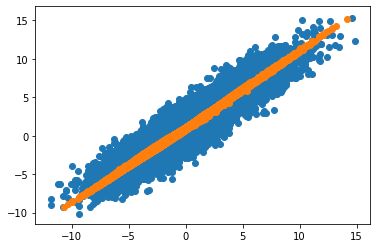

In [146]:
x_mu, x_sigma = model.decoder(torch.randn(10000, 2).to(device))
xs = x_mu + x_sigma * torch.randn_like(x_mu)
plt.scatter(xs[:, 0].cpu().detach().numpy(), xs[:, 1].cpu().detach().numpy())
plt.scatter(x_mu[:, 0].cpu().detach().numpy(), x_mu[:, 1].cpu().detach().numpy())

In [0]:
def sample_data_3():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
data_x, data_y = sample_data_3()
data = torch.from_numpy(data_x[:len(data_x) // 10 * 8]).float()
validate = torch.from_numpy(data_x[len(data_x) // 10 * 8:]).float()



Epoch 9/10. Iteration 798/799 Losses: train: 5.37135124206543

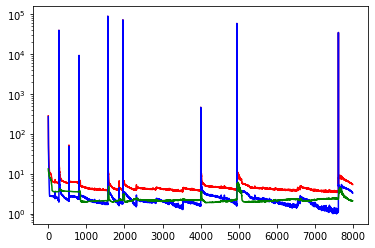

In [166]:
model = VAE(2, hidden=[128, 64, 32], z_size=10).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, eblo_losses, kl_losses = learn(data, model, 10, 100, opt)

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(eblo_losses)), eblo_losses, 'b',
         range(0, len(kl_losses)), kl_losses, 'g'
         )

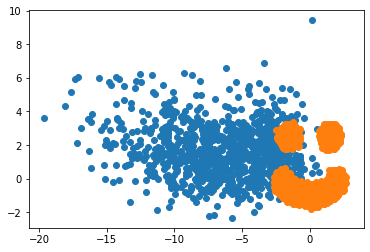

In [172]:
x_mu, x_sigma = model.decoder(torch.randn(1000, 10).to(device))
xs = x_mu + x_sigma * torch.randn_like(x_mu)
plt.scatter(x_mu[:, 0].cpu().detach().numpy(), x_mu[:, 1].cpu().detach().numpy())
plt.scatter(data_x[:, 0], data_x[:, 1])

In [0]:
print(x_sigma.mean(), x_sigma.std())

tensor(1.8816, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8910, device='cuda:0', grad_fn=<StdBackward0>)


In [123]:
print(x_mu.mean(), x_mu.std())

tensor(0.6885, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.7575, device='cuda:0', grad_fn=<StdBackward0>)
